In [1]:
#Imports and setup

#Data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text processing
import re
import string
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix


#Download NLTK resources 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

print("Done")

Done


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jacov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jacov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jacov\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Load csv file
df = pd.read_csv("spam.csv", encoding='latin-1')

df = df[['v1', 'v2']]
df.columns = ['label', 'message']
pd.set_option('display.max_colwidth', None)

df.head(15)

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8,spam,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030


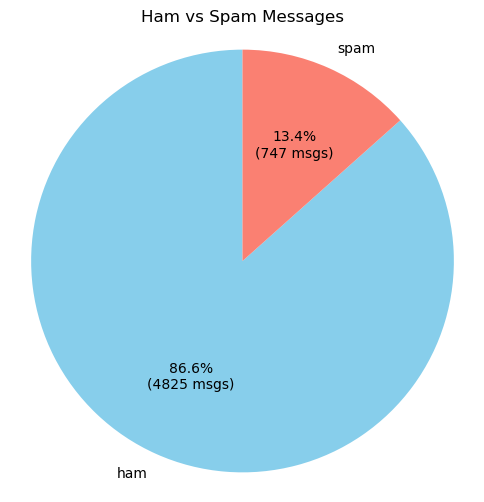

In [3]:
#Pie chart, spam vs ham

label_counts = df['label'].value_counts()
labels = label_counts.index
counts = label_counts.values

#Define function for labels
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count} msgs)'
    return my_autopct

#Plot
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct=make_autopct(counts), startangle=90, colors=['skyblue', 'salmon'])
plt.title('Ham vs Spam Messages')
plt.axis('equal')
plt.savefig("Number of Ham vs Span message in the data set - Pie chart")
plt.show()


In [4]:
#One Hot encoding for ML
#0 for ham and 1 for spam

df['label_num'] = df['label'].map({'ham':0, "spam":1})
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives around here though",0


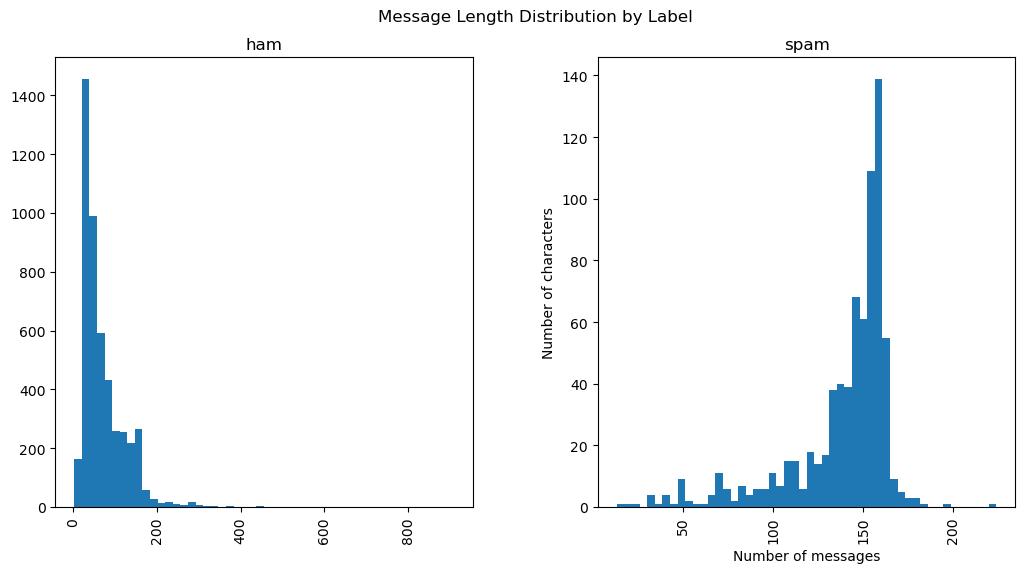

In [5]:
#Comparing length of spam vs ham messages

df['length'] = df['message'].apply(len)

#Histogram
df.hist(column='length', by='label', bins=50, figsize=(12,6))
plt.xlabel('Number of messages')
plt.ylabel('Number of characters')
plt.suptitle('Message Length Distribution by Label')
plt.savefig('Message Length Distribution - Histogram')
plt.show()


In [6]:
#Data preprocessing and data cleaning

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def text_process_string(mess):
    """
    Preprocesses a message by:
    1. Lowercase
    2. Remove punctuation
    3. Tokenize into words
    4. Remove stopwords
    5. Lemmatize
    Returns a list of clean words
    """
    # 1.Lowercase
    mess = mess.lower()
    
    # 2.Remove punctuation
    mess = ''.join([char for char in mess if char not in string.punctuation])
    
    # 3.Tokenize
    tokens = mess.split()
    
    # 4.Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # 5.Lemmatize
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(clean_tokens)

print("successful")


successful


In [7]:
#Test if the cleaning works
test_sentence = "Hello!!! You've won a free trip to London. Call NOW to claim :)"

print(text_process_string(test_sentence))


hello youve free trip london call claim


In [8]:
#Add column with the cleaned message

df['cleaned_tokens'] = df['message'].apply(text_process_string)
df[['message', 'cleaned_tokens']].head()


,message,cleaned_tokens
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",go jurong point crazy available bugis n great world la e buffet cine got amore wat
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives around here though",nah dont think go usf life around though


In [9]:
#Unigrams and Bigrams, limit top 3000 features
tfidf_vect = TfidfVectorizer(preprocessor=text_process_string, ngram_range=(1, 2), max_features=3000)

#Fit and transform cleaned messages
messages_tfidf = tfidf_vect.fit_transform(df['message'])

print("TF-IDF matrix shape:", messages_tfidf.shape)

TF-IDF matrix shape: (5572, 3000)


In [10]:
# Select the 9th message
sample_msg = df['message'][8]

# Transform it using the trained TF-IDF vectorizer
sample_tfidf = tfidf_vect.transform([sample_msg])

# Get non-zero indices (words/phrases that appear in the message)
word_indices = sample_tfidf.nonzero()[1]

# Print feature (word or bigram) and TF-IDF score
for idx in word_indices:
    feature = tfidf_vect.get_feature_names_out()[idx]
    score = sample_tfidf[0, idx]
    print(f"{feature}: {score:.4f}")


12: 0.2488
900: 0.2658
900 prize: 0.2788
call: 0.1205
claim: 0.3576
claim call: 0.2445
claim code: 0.2563
code: 0.2248
customer: 0.2002
hour: 0.2060
network: 0.2236
prize: 0.1873
reward: 0.2697
selected: 0.2260
valid: 0.2341
valued: 0.2536
winner: 0.2466


In [11]:
#Check message length of ham vs spam

df['text_length'] = df['message'].apply(len)
avg_lengths = df.groupby('label')['text_length'].mean()
print(avg_lengths)


label
ham      71.023627
spam    138.866131
Name: text_length, dtype: float64


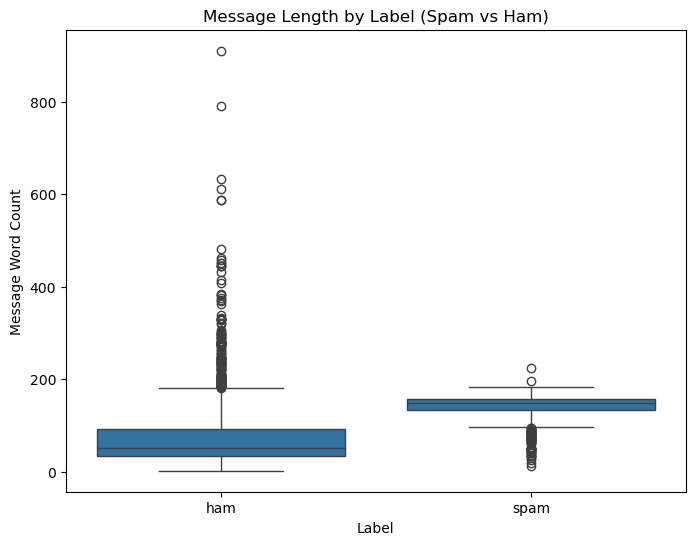

In [12]:
#Box plot to get better understanding of data spread

plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='label', y='text_length')
plt.title("Message Length by Label (Spam vs Ham)")
plt.xlabel("Label")
plt.ylabel("Message Word Count")
plt.savefig('Message length, ham vs spam boxplot')
plt.show()


In [13]:
#Split data for the model
#Training - 80%
#Validation - 10%
#Test - 10%


In [14]:
#Features (X) are the TF-IDF vectors;
#Labels (y) are the 0 (ham) or 1 (spam)

X = messages_tfidf
y = df['label_num'] 

#Split: 80% train
#20% temp 
#random_state=42 for reproducibility

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

#Split temp into 10% validation and 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)


Train size: (4457, 3000)
Validation size: (557, 3000)
Test size: (558, 3000)


In [15]:
#Define model
#Naive Bayes Model - nb

nb_model = MultinomialNB()

nb_model.fit(X_train, y_train)

print('Model training complete')

Model training complete


In [16]:
#Evaluate the model on validation (10%) set 

#Predict on validation set
y_val_pred = nb_model.predict(X_val)

#Evaluation
print("Validation Results:")
print("\n")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("\n")
print(classification_report(y_val, y_val_pred))

Validation Results:


Accuracy: 0.9712746858168761


              precision    recall  f1-score   support

           0       0.97      1.00      0.98       473
           1       1.00      0.81      0.89        84

    accuracy                           0.97       557
   macro avg       0.98      0.90      0.94       557
weighted avg       0.97      0.97      0.97       557



In [17]:
#Final evaluation on the test set

#predict on the test set
y_test_pred = nb_model.predict(X_test)

#Evaluation
print("Test results: ")
print("\n")
print("Accuracy: ", accuracy_score(y_test, y_test_pred))
print("\n")
print(classification_report(y_test, y_test_pred))

Test results: 


Accuracy:  0.978494623655914


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       492
           1       0.97      0.85      0.90        66

    accuracy                           0.98       558
   macro avg       0.97      0.92      0.95       558
weighted avg       0.98      0.98      0.98       558



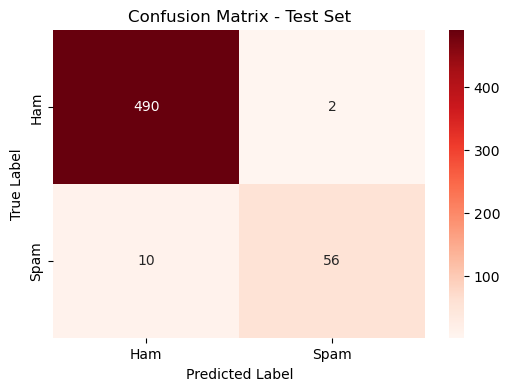

In [18]:
#Generate confusion matrix for test set
cm = confusion_matrix(y_test, y_test_pred)

#Define class labels
labels = ['Ham', 'Spam']

#Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.savefig('Confusion Matrix')
plt.show()

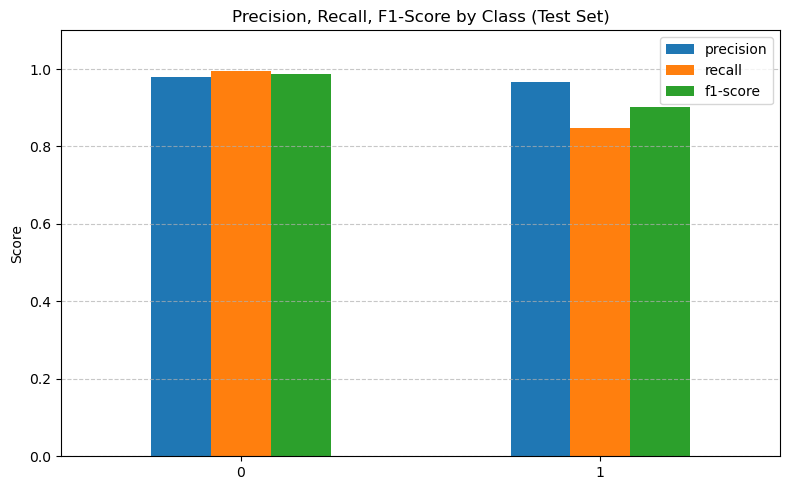

In [19]:
#Get classification report as dictionary
report = classification_report(y_test, y_test_pred, output_dict=True)

#Convert to DataFrame (excluding overall accuracy/macro/weighted if not needed)
report_df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])

#Plot
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(8, 5))
plt.title('Precision, Recall, F1-Score by Class (Test Set)')
plt.xticks(rotation=0)
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Classification report Bar plot')
plt.show()
